In [1]:
import os
# import open3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from matplotlib import colors
plt.rcParams["font.family"] = "serif" # Font controller
plt.rcParams["font.serif"] = ["Arial"]
plt.rcParams["font.size"] = 11 # Default=10
import pickle
import vis_utilities as vis_util
import eval_utilities as eval_util

BASE_CFG_list = ['octree-raht', 'octree-predlift', 'predgeom-raht', 'predgeom-predlift']
SUB_CFG_dict = {'octree-raht':['octree_raht_lossy_lossy_no_dup', 'octree_raht_lossy_lossy_keep_dup', 
                               'octree_raht_lossy_lossy_no_dup_distance'],
               'octree-predlift':['lossy-geom-lossy-attrs'],
               'predgeom-raht':['lossy-geom-lossy-attrs'],
               'predgeom-predlift':['lossy-geom-lossy-attrs']}
rate_list_dict = {'octree-raht':[[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 3]],
               'octree-predlift':[[1, 2, 3, 4, 5, 6]],
               'predgeom-raht':[[1, 2, 3, 4, 5, 6]],
               'predgeom-predlift':[[1, 2, 3, 4, 5, 6]]}

class_list=['Car','Pedestrian','Cyclist']
difficulty_list=['Easy','Mod.','Hard']

bitrate_root = '/home/user/PCcompression/Results/GPCC_files/output_kitti_training/'

range_type_list=[0, 1, 2, 3, 4]
result_dir_root='/home/user/PCcompression/Results/AP_files/raw'
metric = 'mAP3d_R40'
IoU_criteria=0 

for obj_class, obj_class_name in enumerate(class_list):
    AP_all_ranges = []
    for range_type in range_type_list:
        result_dir = result_dir_root + '/range_'+str(range_type)+'/'
        metrics = eval_util.load_AP_single_setting(result_dir)
        AP_all_ranges.append(metrics)

# plt.savefig(figure_dir +'AP_vs_distance_raw.pdf',format='pdf',bbox_inches='tight')
AP_all_ranges_raw = AP_all_ranges

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


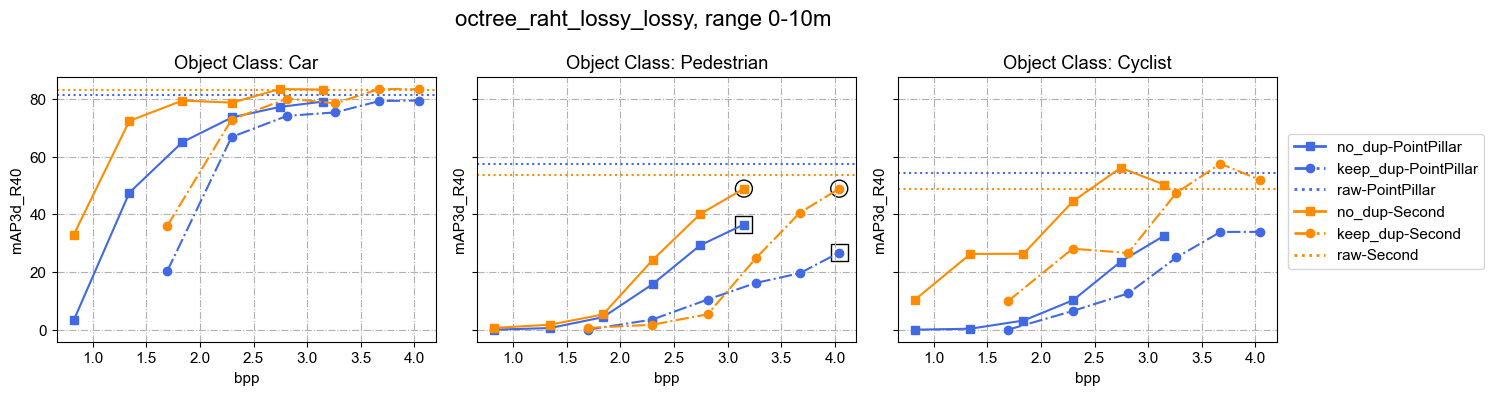

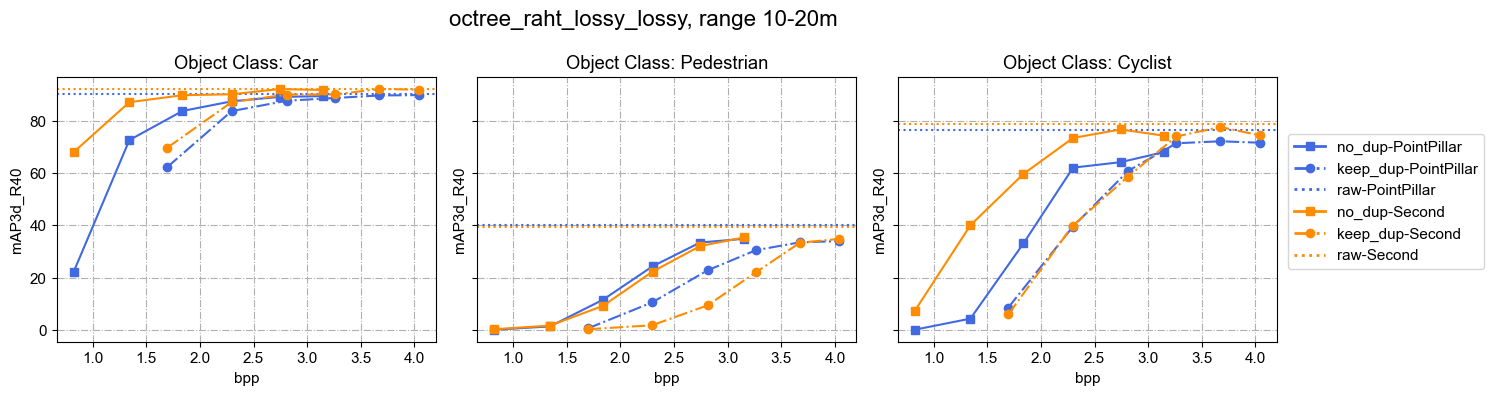

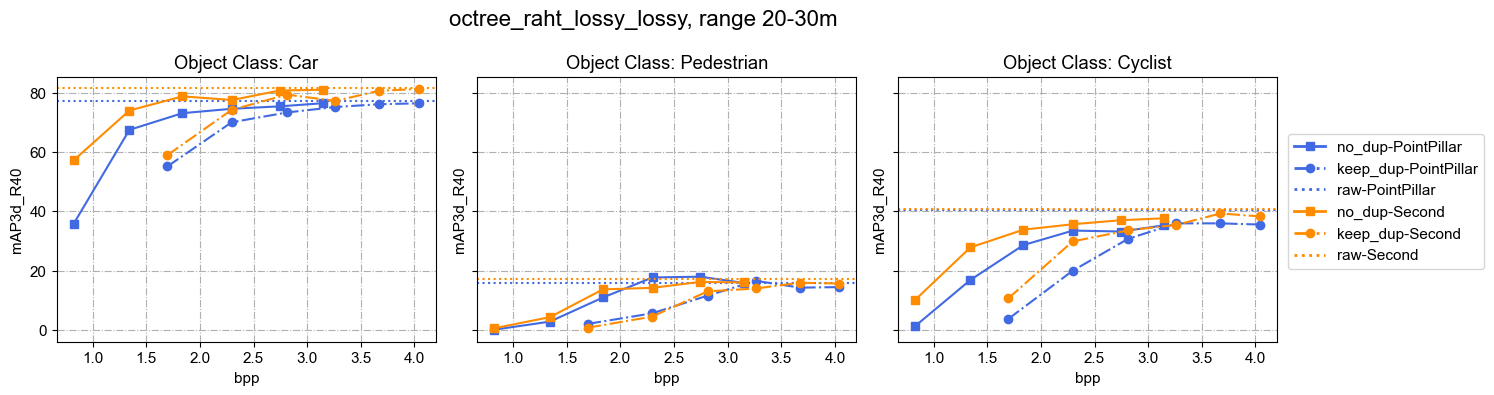

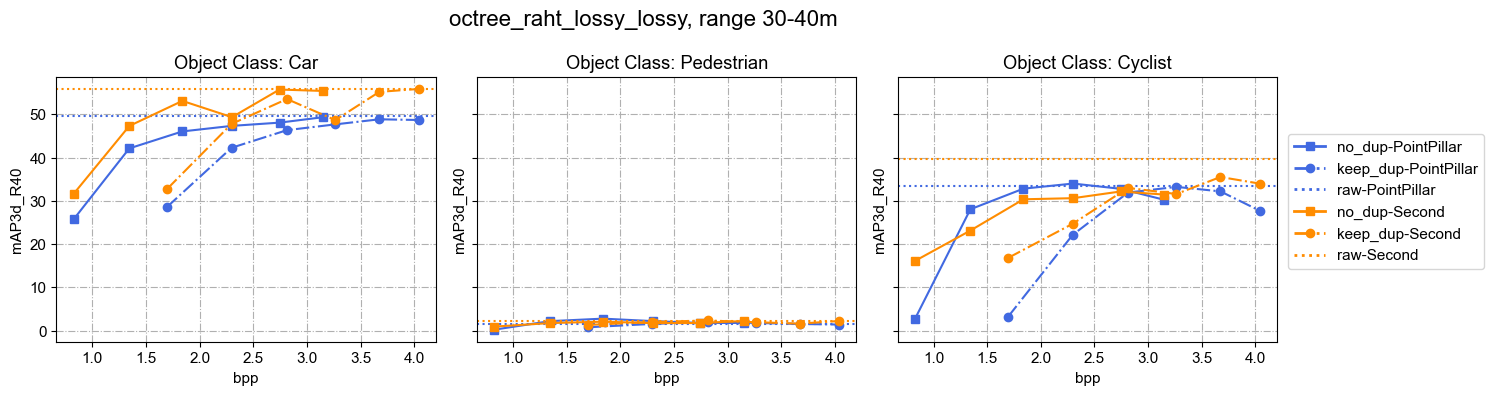

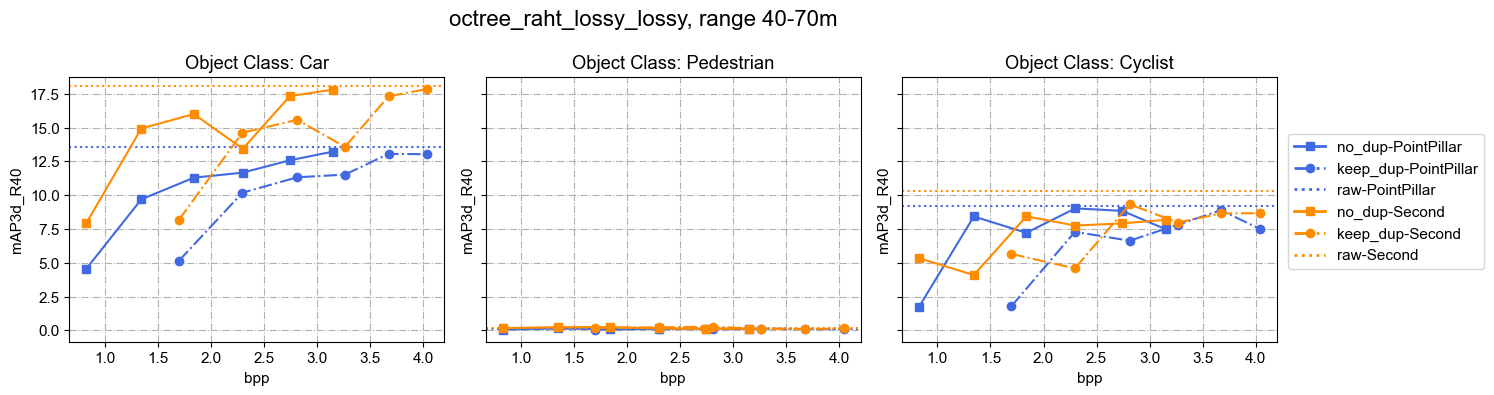

In [2]:
import matplotlib.lines as mlines

BASE_CFG_list = ['octree-raht']
edges_txt = ['0-10', '10-20','20-30','30-40','40-70']
metric = 'mAP3d_R40'
IoU_criteria = 0 
difficulty = 1
AP_data_dir_roots = ['/home/user/PCcompression/Results/AP_files/', '/home/user/PCcompression/Results/AP_files_second/']
raw_dir_roots = ['/home/user/PCcompression/Results/AP_files/raw', '/home/user/PCcompression/Results/AP_files_second/raw']
bitrate_root = '/home/user/PCcompression/Results/GPCC_files/output_kitti_training/'
styles = ['-', '-.']
markers = ['s', 'o']
colors = ['royalblue', 'darkorange']
models = ['PointPillar', 'Second']

range_types = [0, 1, 2, 3, 4]
for range_type in range_types:
    # Plot the mAP for each object class
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
    fig.set_size_inches(13,4)
    legend_elements = []

    for model_ind, AP_data_dir_root in enumerate(AP_data_dir_roots):
        raw_dir_root = raw_dir_roots[model_ind]

        for BASE_CFG in BASE_CFG_list:
            for rate_list_ind, SUB_CFG in enumerate(SUB_CFG_dict[BASE_CFG][:2]):
                
                rate_list = rate_list_dict[BASE_CFG][rate_list_ind] # the rate list for the CFG

                result_dir_root = AP_data_dir_root + BASE_CFG + '/' + SUB_CFG + '/'
                bitrate_dir = bitrate_root + BASE_CFG + '/' + SUB_CFG + '/'

                rets = eval_util.load_one_CFG_dir(BASE_CFG, SUB_CFG, AP_data_dir_root, rate_list, bitrate_dir)
                metrics_cfg, CFG_full_name, rate_dict, rate_list = rets

                for obj_class, obj_class_name in enumerate(class_list):
                    AP_all_rates = []
                    for rate_ind, rate in enumerate(rate_list):
                        

                        result_dir = result_dir_root +'r0'+str(rate) + '/range_' + str(range_type) + '/'
                        metrics = eval_util.load_AP_single_setting(result_dir)
                        AP_all_rates.append(metrics)

                    AP = [AP_all_rates[i][metric][obj_class, difficulty, IoU_criteria] for i, _ in enumerate(rate_list)]
                    axs[obj_class].plot(rate_dict['total_bpp'], AP, ls=styles[rate_list_ind], marker=markers[rate_list_ind],
                                         c=colors[model_ind], label=SUB_CFG[24:])# Missing x

                    axs[obj_class].set_ylabel(metric)
                    axs[obj_class].set_xlabel('bpp')
                    axs[obj_class].set_title('Object Class: '+obj_class_name)
                    axs[obj_class].grid(True, linestyle='-.')
                    # axs[obj_class].set_xticks(range(0, len(edges)), edges_txt)
                    if range_type == 0 and obj_class_name == 'Pedestrian':
                        axs[obj_class].scatter(rate_dict['total_bpp'][-1], AP[-1], marker=markers[model_ind], s=150, facecolors='none', edgecolors='black')
                    
                legend_elements.append(mlines.Line2D([0], [0], c=colors[model_ind], lw=2, marker=markers[rate_list_ind], 
                                                     ls=styles[rate_list_ind], label=SUB_CFG[24:]+'-'+models[model_ind]))
        
        for obj_class, obj_class_name in enumerate(class_list):
            result_dir = raw_dir_root + '/range_'+str(range_type)+'/'
            metrics = eval_util.load_AP_single_setting(result_dir)
            standard = metrics[metric][obj_class, difficulty, IoU_criteria]
            axs[obj_class].axhline(y=standard, xmin=0, xmax=rate_dict['total_bpp'][-1], label='raw', ls=':', c=colors[model_ind], marker='None')
            # axs[obj_class].legend(loc='upper right')
        legend_elements.append(mlines.Line2D([0], [0], c=colors[model_ind], lw=2,
                                                     ls=':', label='raw'+'-'+models[model_ind]))

    fig.suptitle(SUB_CFG[:23] + ', range {}m'.format(edges_txt[range_type]), fontsize=16)
    # print(len(legend_elements))
    fig.legend(handles=legend_elements, bbox_to_anchor=(0.99, 0.5), loc='center left')


In [3]:
BASE_CFG_list = ['octree-raht', 'octree-predlift', 'predgeom-raht', 'predgeom-predlift']
SUB_CFG_dict = {'octree-raht':['octree_raht_lossy_lossy_no_dup',
                               'octree_raht_lossy_lossy_no_dup_distance'],
               'octree-predlift':['lossy-geom-lossy-attrs'],
               'predgeom-raht':['lossy-geom-lossy-attrs'],
               'predgeom-predlift':['lossy-geom-lossy-attrs']}
rate_list_dict = {'octree-raht':[[4, 5, 6], [1, 2, 3]],
               'octree-predlift':[[1, 2, 3, 4, 5, 6]],
               'predgeom-raht':[[1, 2, 3, 4, 5, 6]],
               'predgeom-predlift':[[1, 2, 3, 4, 5, 6]]}

class_list=['Car','Pedestrian','Cyclist']
difficulty_list=['Easy','Mod.','Hard']

6


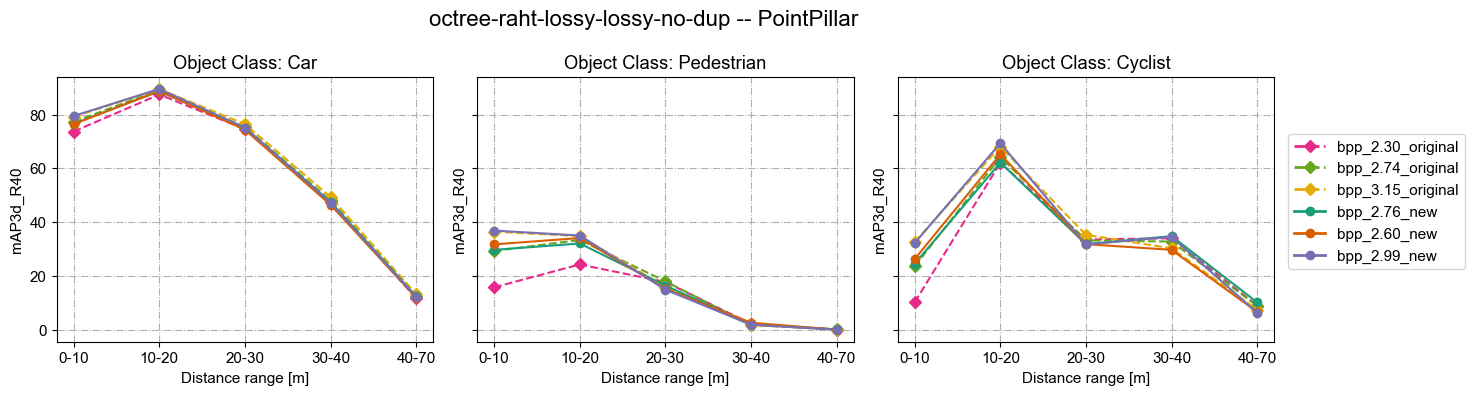

In [7]:
## Point Pillar
import matplotlib.lines as mlines

consistent_colormap = plt.cm.get_cmap('Dark2')

BASE_CFG_list = ['octree-raht']
edges = np.array([[0, 10], [10, 20], [20, 30], [30, 40],
                  [40, 70]])
edges_txt = ['0-10', '10-20','20-30','30-40','40-70']
metric = 'mAP3d_R40'
IoU_criteria = 0 
difficulty = 1
AP_data_dir_root = '/home/user/PCcompression/Results/AP_files/'
bitrate_root = '/home/user/PCcompression/Results/GPCC_files/output_kitti_training/'

range_types = [0, 1, 2, 3, 4]
styles = ['D--', 'o-']
legend_elements = []
linestyles = ['--', '-']
markers = ['D', 'o']
labels = ['original', 'new']


fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
fig.set_size_inches(13,4)
for BASE_CFG in BASE_CFG_list:
    for rate_list_ind, SUB_CFG in enumerate(SUB_CFG_dict[BASE_CFG]):
        # Plot the mAP for each object class
        
        rate_list = rate_list_dict[BASE_CFG][rate_list_ind] # the rate list for the CFG

        result_dir_root = AP_data_dir_root + BASE_CFG + '/' + SUB_CFG + '/'
        bitrate_dir = bitrate_root + BASE_CFG + '/' + SUB_CFG + '/'

        rets = eval_util.load_one_CFG_dir(BASE_CFG, SUB_CFG, AP_data_dir_root, rate_list, bitrate_dir)
        metrics_cfg, CFG_full_name, rate_dict, rate_list = rets

        for obj_class, obj_class_name in enumerate(class_list):
            AP_raw_array = [AP_all_ranges_raw[range_type][metric][obj_class, difficulty, IoU_criteria] for range_type in range_type_list]
            for rate_ind, rate in enumerate(rate_list):
                AP_all_rates = []
                for range_type  in range_types:
                    result_dir = result_dir_root +'r0'+str(rate) + '/range_' + str(range_type) + '/'
                    metrics = eval_util.load_AP_single_setting(result_dir)
                    AP_all_rates.append(metrics)

                
                AP = [AP_all_rates[i][metric][obj_class, difficulty, IoU_criteria] for i, _ in enumerate(range_types)]
                axs[obj_class].plot(range_types, AP, styles[rate_list_ind], color=consistent_colormap.colors[rate-1], 
                                    label='bpp_{:.2f}_'.format(rate_dict['total_bpp'][rate_ind]) + labels[rate_list_ind])# Missing x
                
                if obj_class == 0:
                    legend_elements.append(mlines.Line2D([0], [0], marker=markers[rate_list_ind],
                                                         c=consistent_colormap.colors[rate-1], lw=2, ls=linestyles[rate_list_ind], 
                                                         label='bpp_{:.2f}_'.format(rate_dict['total_bpp'][rate_ind]) + labels[rate_list_ind]))
            axs[obj_class].set_ylabel(metric)
            axs[obj_class].set_xlabel('Distance range [m]')
            axs[obj_class].set_title('Object Class: '+obj_class_name)
            axs[obj_class].grid(True, linestyle='-.')
            axs[obj_class].set_xticks(range(0, len(edges)), edges_txt)
                # axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
            # axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
            # axs[obj_class].legend(loc='upper right')

        
print(len(legend_elements))
fig.suptitle('octree-raht-lossy-lossy-no-dup -- PointPillar', fontsize=16)
fig.legend(handles=legend_elements, bbox_to_anchor=(0.99, 0.5), loc='center left')


        

6


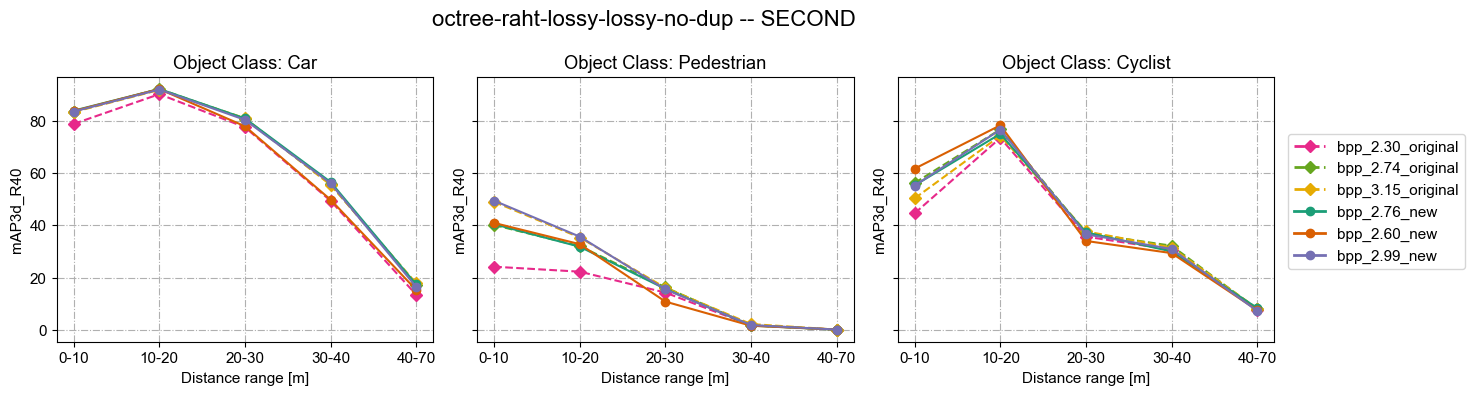

In [5]:
## SECOND
import matplotlib.lines as mlines

consistent_colormap = plt.cm.get_cmap('Dark2')

BASE_CFG_list = ['octree-raht']
edges = np.array([[0, 10], [10, 20], [20, 30], [30, 40],
                  [40, 70]])
edges_txt = ['0-10', '10-20','20-30','30-40','40-70']
metric = 'mAP3d_R40'
IoU_criteria = 0 
difficulty = 1
AP_data_dir_root = '/home/user/PCcompression/Results/AP_files_second/'
bitrate_root = '/home/user/PCcompression/Results/GPCC_files/output_kitti_training/'

range_types = [0, 1, 2, 3, 4]
styles = ['D--', 'o-']
legend_elements = []
linestyles = ['--', '-']
markers = ['D', 'o']
labels = ['original', 'new']


fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
fig.set_size_inches(13,4)
for BASE_CFG in BASE_CFG_list:
    for rate_list_ind, SUB_CFG in enumerate(SUB_CFG_dict[BASE_CFG]):
        # Plot the mAP for each object class
        
        rate_list = rate_list_dict[BASE_CFG][rate_list_ind] # the rate list for the CFG

        result_dir_root = AP_data_dir_root + BASE_CFG + '/' + SUB_CFG + '/'
        bitrate_dir = bitrate_root + BASE_CFG + '/' + SUB_CFG + '/'

        rets = eval_util.load_one_CFG_dir(BASE_CFG, SUB_CFG, AP_data_dir_root, rate_list, bitrate_dir)
        metrics_cfg, CFG_full_name, rate_dict, rate_list = rets

        for obj_class, obj_class_name in enumerate(class_list):
            AP_raw_array = [AP_all_ranges_raw[range_type][metric][obj_class, difficulty, IoU_criteria] for range_type in range_type_list]
            for rate_ind, rate in enumerate(rate_list):
                AP_all_rates = []
                for range_type  in range_types:
                    result_dir = result_dir_root +'r0'+str(rate) + '/range_' + str(range_type) + '/'
                    metrics = eval_util.load_AP_single_setting(result_dir)
                    AP_all_rates.append(metrics)

                
                AP = [AP_all_rates[i][metric][obj_class, difficulty, IoU_criteria] for i, _ in enumerate(range_types)]
                axs[obj_class].plot(range_types, AP, styles[rate_list_ind], color=consistent_colormap.colors[rate-1], 
                                    label='bpp_{:.2f}_'.format(rate_dict['total_bpp'][rate_ind]) + labels[rate_list_ind])# Missing x
                
                if obj_class == 0:
                    legend_elements.append(mlines.Line2D([0], [0], marker=markers[rate_list_ind],
                                                         c=consistent_colormap.colors[rate-1], lw=2, ls=linestyles[rate_list_ind], 
                                                         label='bpp_{:.2f}_'.format(rate_dict['total_bpp'][rate_ind]) + labels[rate_list_ind]))
            axs[obj_class].set_ylabel(metric)
            axs[obj_class].set_xlabel('Distance range [m]')
            axs[obj_class].set_title('Object Class: '+obj_class_name)
            axs[obj_class].grid(True, linestyle='-.')
            axs[obj_class].set_xticks(range(0, len(edges)), edges_txt)
                # axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
            # axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
            # axs[obj_class].legend(loc='upper right')

        
print(len(legend_elements))
fig.suptitle('octree-raht-lossy-lossy-no-dup -- SECOND', fontsize=16)
fig.legend(handles=legend_elements, bbox_to_anchor=(0.99, 0.5), loc='center left')


        